In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
import os
from datetime import datetime
import io

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# 0. ARTIFACT SAVING SETUP

In [ ]:
## 0.1 Create Output Directories

In [ ]:
def setup_output_directories():
    """Create necessary directories for saving EDA artifacts."""
    base_dir = Path(__file__).parent
    output_dir = base_dir / 'specs' / 'output'
    figures_dir = output_dir / 'figures'
    data_dir = output_dir / 'data'

    # Create directories if they don't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    figures_dir.mkdir(parents=True, exist_ok=True)
    data_dir.mkdir(parents=True, exist_ok=True)

    return output_dir, figures_dir, data_dir

# Setup directories
OUTPUT_DIR, FIGURES_DIR, DATA_DIR = setup_output_directories()

In [ ]:
## 0.2 Console Output Capture Setup
class OutputCapture:
    """Capture console output for saving to report file."""
    def __init__(self, output_dir):
        self.output_dir = Path(output_dir)
        self.captured_output = []
        self.original_stdout = sys.stdout

    def start_capture(self):
        """Start capturing console output."""
        sys.stdout = self

    def stop_capture(self):
        """Stop capturing and restore original stdout."""
        sys.stdout = self.original_stdout

    def write(self, text):
        """Write to both original stdout and capture buffer."""
        self.original_stdout.write(text)
        self.captured_output.append(text)

    def flush(self):
        """Flush the original stdout."""
        self.original_stdout.flush()

    def save_report(self, filename="eda-report.md"):
        """Save captured output to markdown file."""
        report_path = self.output_dir / filename

        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(f"# EDA Report - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            f.write("This report contains the complete console output from the EDA process.\n\n")
            f.write("```\n")
            f.write(''.join(self.captured_output))
            f.write("\n```\n")

        return report_path

# Initialize output capture
output_capture = OutputCapture(OUTPUT_DIR)

In [ ]:
## 0.3 Figure Saving Helper
figure_counter = 0
saved_figures = []

def save_figure(title, description="", show=True):
    """Save current matplotlib figure with metadata."""
    global figure_counter, saved_figures

    figure_counter += 1
    filename = f"figure_{figure_counter:02d}_{title.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')}.png"
    filepath = FIGURES_DIR / filename

    # Save the figure
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')

    # Store metadata
    saved_figures.append({
        'number': figure_counter,
        'filename': filename,
        'title': title,
        'description': description,
        'filepath': str(filepath)
    })

    if show:
        plt.show()

    return filepath

In [ ]:
# 1. SETUP AND CONFIGURATION

In [ ]:
## 1.1 Set Visualization Styles
plt.style.use('ggplot')
sns.set_style("whitegrid")
sns.set_palette("husl")

In [ ]:
# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

In [ ]:
# Start capturing console output for report generation
output_capture.start_capture()

print("=" * 80)
print("AI-VIVE-BANKING TERM DEPOSIT PREDICTION - EXPLORATORY DATA ANALYSIS")
print("=" * 80)
print("Data Source: bmarket.db (SQLite Database)")
print("Business Objective: Predict term deposit subscription likelihood")
print("Focus: Marketing campaign optimization and client targeting")
print("ARTIFACT SAVING: Enabled - Saving to specs/output/")
print("=" * 80)

AI-VIVE-BANKING TERM DEPOSIT PREDICTION - EXPLORATORY DATA ANALYSIS
Data Source: bmarket.db (SQLite Database)
Business Objective: Predict term deposit subscription likelihood
Focus: Marketing campaign optimization and client targeting
ARTIFACT SAVING: Enabled - Saving to specs/output/



📊 LOADING DATA FROM: c:\Users\ellie\VSProjects\aisg\aiap20\data\raw\bmarket.db
--------------------------------------------------
✅ Connected to database successfully
📋 Using table: bank_marketing
✅ Data loaded successfully:
   • Rows: 41,188
   • Columns: 12
   • Memory usage: 19.62 MB
✅ Database connection closed

2. DATA OVERVIEW AND QUALITY ASSESSMENT

📋 DATASET OVERVIEW
------------------------------
Dataset Shape: 41,188 rows × 12 columns
Data Source: bmarket.db - bank_marketing table
Business Context: Banking marketing campaign data for term deposit prediction

📊 COLUMN INFORMATION
------------------------------
Column Names and Data Types:
 1. Client ID                 | int64     
 2. Age                       | object    
 3. Occupation                | object    
 4. Marital Status            | object    
 5. Education Level           | object    
 6. Credit Default            | object    
 7. Housing Loan              | object    
 8. Personal Loan             | object    

In [ ]:
## 1.2 Database Connection and Data Loading

In [ ]:
def load_banking_data() -> pd.DataFrame:
    """
    Load banking marketing data from bmarket.db with comprehensive error handling.

    Returns:
        pd.DataFrame: Complete banking marketing dataset
    """
    # Set up path to database using os.path for cross-platform compatibility
    base_dir = Path(__file__).parent
    db_path = base_dir / 'data' / 'raw' / 'bmarket.db'

    print(f"\n📊 LOADING DATA FROM: {db_path}")
    print("-" * 50)

    try:
        # Connect to the SQLite database
        conn = sqlite3.connect(db_path)
        print("✅ Connected to database successfully")

        # Get table information
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
        tables = [row[0] for row in cursor.fetchall()]

        if not tables:
            raise ValueError("No tables found in database")

        # Use the bank_marketing table (primary table)
        table_name = 'bank_marketing'
        if table_name not in tables:
            table_name = tables[0]  # Fallback to first table

        print(f"📋 Using table: {table_name}")

        # Load complete dataset
        query = f"SELECT * FROM {table_name};"
        df = pd.read_sql_query(query, conn)

        print(f"✅ Data loaded successfully:")
        print(f"   • Rows: {df.shape[0]:,}")
        print(f"   • Columns: {df.shape[1]}")
        print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

        # Close connection
        conn.close()
        print("✅ Database connection closed")

        return df

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        if 'conn' in locals():
            conn.close()
        raise

# Load the data
df = load_banking_data()

In [ ]:
# 2. INITIAL DATA EXPLORATION AND QUALITY ASSESSMENT

In [ ]:
print("\n" + "=" * 80)
print("2. DATA OVERVIEW AND QUALITY ASSESSMENT")
print("=" * 80)

In [ ]:
## 2.1 Dataset Overview
print("\n📋 DATASET OVERVIEW")
print("-" * 30)
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Data Source: bmarket.db - bank_marketing table")
print(f"Business Context: Banking marketing campaign data for term deposit prediction")

In [ ]:
## 2.2 Column Information
print("\n📊 COLUMN INFORMATION")
print("-" * 30)
print("Column Names and Data Types:")
for i, (col, dtype) in enumerate(df.dtypes.items(), 1):
    print(f"{i:2d}. {col:<25} | {str(dtype):<10}")

In [ ]:
## 2.3 Data Quality Assessment
print("\n🔍 DATA QUALITY ASSESSMENT")
print("-" * 30)

In [ ]:
# Missing values analysis
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

In [ ]:
print("Missing Values Analysis:")
if missing_data.sum() == 0:
    print("✅ No missing values detected")
else:
    missing_df = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing %': missing_percent
    }).sort_values('Missing Count', ascending=False)
    print(missing_df[missing_df['Missing Count'] > 0])

In [ ]:
# Unique values count
print("\nUnique Values per Column:")
unique_counts = df.nunique().sort_values()
for col, count in unique_counts.items():
    print(f"  {col:<25}: {count:>6} unique values")

In [ ]:
## 2.4 Target Variable Analysis
print("\n🎯 TARGET VARIABLE ANALYSIS")
print("-" * 30)

In [ ]:
## 2.4 Target Variable Analysis
print("\n🎯 TARGET VARIABLE ANALYSIS")
print("-" * 30)

target_col = 'Subscription Status'
if target_col in df.columns:
    target_dist = df[target_col].value_counts()
    target_pct = df[target_col].value_counts(normalize=True) * 100

    print(f"Target Variable: {target_col}")
    print("Distribution:")
    for value, count in target_dist.items():
        pct = target_pct[value]
        print(f"  {value:<10}: {count:>6,} ({pct:5.1f}%)")

    # Calculate class imbalance ratio
    if len(target_dist) == 2:
        minority_class = target_dist.min()
        majority_class = target_dist.max()
        imbalance_ratio = majority_class / minority_class
        print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")

        if imbalance_ratio > 3:
            print("⚠️  Significant class imbalance detected - consider balancing techniques")
        else:
            print("✅ Reasonable class balance")
else:
    print(f"❌ Target column '{target_col}' not found")

In [ ]:
## 2.5 Data Sample Display
print("\n📄 DATA SAMPLE")
print("-" * 30)
print("First 5 rows:")
print(df.head().to_string())

print("\nLast 5 rows:")
print(df.tail().to_string())

In [ ]:
print("\n" + "=" * 80)
print("3. RAW DATA QUALITY ASSESSMENT FOR PHASE 3 PREPARATION")
print("=" * 80)

## 3.1 Identify Data Quality Issues for Phase 3 Cleaning
print("\n🔍 DATA QUALITY ISSUES IDENTIFICATION")
print("-" * 45)

# Work with raw data copy for analysis only (no modifications)
df_raw = df.copy()

In [ ]:
print("Identifying special values that need Phase 3 cleaning:")
special_values = ['unknown', 'Unknown', '999', 'none', 'None', 'NULL', 'null']

special_value_summary = {}
for col in df_raw.columns:
    if df_raw[col].dtype == 'object':
        special_found = []
        for special_val in special_values:
            count = (df_raw[col] == special_val).sum()
            if count > 0:
                special_found.append(f"{special_val}: {count}")
                if col not in special_value_summary:
                    special_value_summary[col] = {}
                special_value_summary[col][special_val] = count

        if special_found:
            print(f"  {col}: {', '.join(special_found)}")

In [ ]:
print("\nAge column format analysis:")
if 'Age' in df_raw.columns:
    print(f"  • Data type: {df_raw['Age'].dtype}")
    print(f"  • Sample values: {df_raw['Age'].head().tolist()}")

    # Check if age needs conversion from text to numeric
    age_sample = df_raw['Age'].dropna().head(10)
    numeric_pattern_found = any(str(val).replace('.', '', 1).isdigit() for val in age_sample)

    if df_raw['Age'].dtype == 'object':
        print("  ⚠️  Age stored as text - needs conversion to numeric in Phase 3")
    else:
        print("  ✅ Age already in numeric format")

In [ ]:
## 3.3 Campaign Calls Analysis (999 Values)
print("\nCampaign Calls special values analysis:")
if 'Campaign Calls' in df_raw.columns:
    calls_999 = (df_raw['Campaign Calls'] == 999).sum()
    if calls_999 > 0:
        print(f"  ⚠️  Found {calls_999} rows with '999' campaign calls")
        print("     → Phase 3 action: Handle as missing/unknown values")
    else:
        print("  ✅ No '999' values found in Campaign Calls")

In [ ]:
## 3.4 Previous Contact Days Analysis (999 Values)
print("\nPrevious Contact Days special values analysis:")
if 'Previous Contact Days' in df_raw.columns:
    prev_999 = (df_raw['Previous Contact Days'] == 999).sum()
    if prev_999 > 0:
        print(f"  ⚠️  Found {prev_999} rows with '999' previous contact days")
        print("     → Phase 3 action: Create 'No Previous Contact' flag")
    else:
        print("  ✅ No '999' values found in Previous Contact Days")

In [ ]:
## 3.5 Target Variable Format Analysis
print("\nTarget variable format analysis:")
if target_col in df_raw.columns:
    target_values = df_raw[target_col].value_counts()
    print(f"  • Target variable: {target_col}")
    print(f"  • Data type: {df_raw[target_col].dtype}")
    print(f"  • Unique values: {target_values.index.tolist()}")
    print("  → Phase 3 action: Convert to binary encoding (1=yes, 0=no)")

print("\n📋 PHASE 3 CLEANING REQUIREMENTS IDENTIFIED")
print("   → Age conversion from text to numeric")
print("   → Special value handling (999, unknown)")
print("   → Target variable binary encoding")
print("   → Missing value strategy implementation")

In [ ]:
# 4. DESCRIPTIVE STATISTICS AND DISTRIBUTIONS

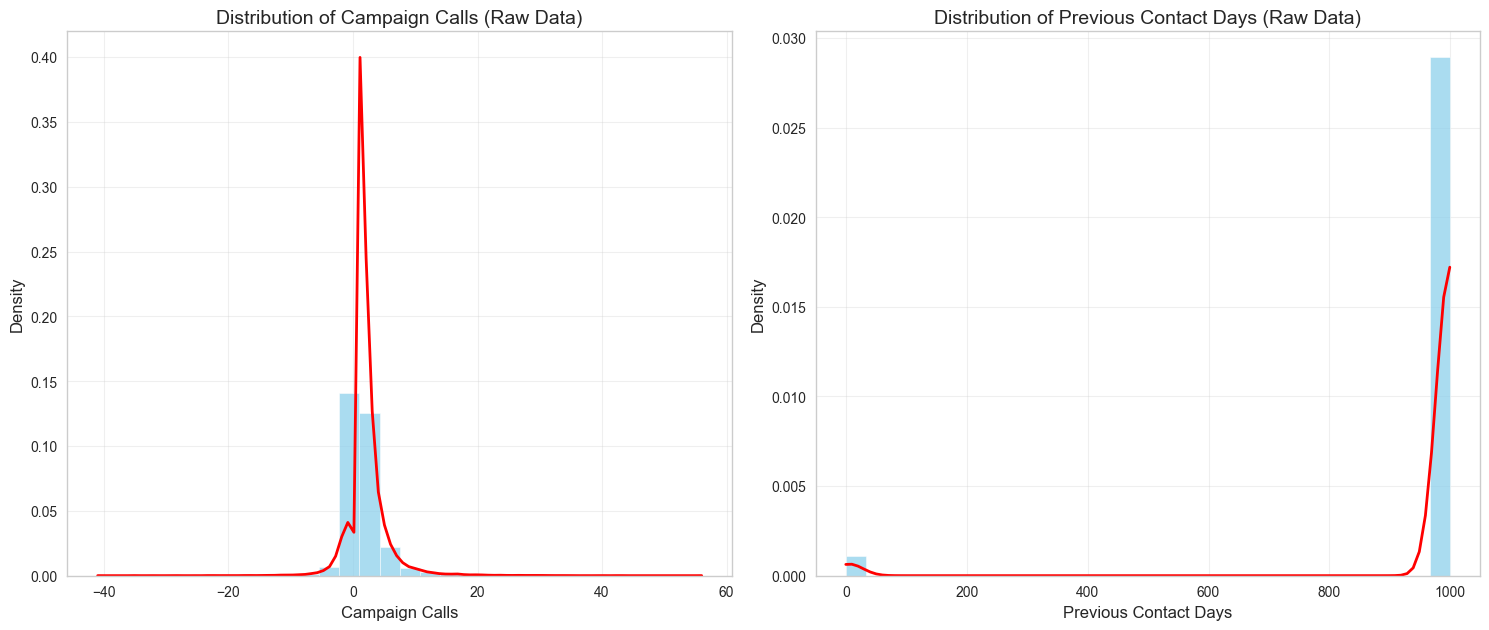

In [ ]:
print("\n" + "=" * 80)
print("4. DESCRIPTIVE STATISTICS AND FEATURE DISTRIBUTIONS")
print("=" * 80)

## 4.1 Numerical Features Analysis (Raw Data)
print("\n📊 NUMERICAL FEATURES ANALYSIS (RAW DATA)")
print("-" * 50)

# Identify numerical columns in raw data
numerical_cols = ['Campaign Calls', 'Previous Contact Days']
# Note: Age is stored as text and will need conversion in Phase 3
if 'Age' in df_raw.columns and df_raw['Age'].dtype in ['int64', 'float64']:
    numerical_cols.append('Age')

numerical_cols = [col for col in numerical_cols if col in df_raw.columns]

if numerical_cols:
    print("Descriptive Statistics for Numerical Features (Raw Data):")
    print(df_raw[numerical_cols].describe().round(2))

    # Create distribution plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for i, col in enumerate(numerical_cols):
        if i < len(axes):
            # Histogram with KDE
            axes[i].hist(df_raw[col].dropna(), bins=30, alpha=0.7, density=True, color='skyblue')

            # Add KDE line
            try:
                from scipy.stats import gaussian_kde
                kde_data = df_raw[col].dropna()
                if len(kde_data) > 1:
                    kde = gaussian_kde(kde_data)
                    x_range = np.linspace(kde_data.min(), kde_data.max(), 100)
                    axes[i].plot(x_range, kde(x_range), 'r-', linewidth=2)
            except:
                pass

            axes[i].set_title(f'Distribution of {col} (Raw Data)')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Density')
            axes[i].grid(True, alpha=0.3)

    # Remove empty subplots
    for i in range(len(numerical_cols), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    save_figure("numerical_features_distributions",
                "Distribution plots for numerical features in raw data with histograms and KDE curves")

In [ ]:
## 4.2 Categorical Features Analysis (Raw Data)
print("\n📊 CATEGORICAL FEATURES ANALYSIS (RAW DATA)")
print("-" * 50)

categorical_cols = ['Occupation', 'Marital Status', 'Education Level', 'Credit Default',
                   'Housing Loan', 'Personal Loan', 'Contact Method']
categorical_cols = [col for col in categorical_cols if col in df_raw.columns]

print("Categorical Features Summary (Raw Data):")
for col in categorical_cols:
    unique_count = df_raw[col].nunique()
    most_common = df_raw[col].value_counts().index[0]
    most_common_pct = (df_raw[col].value_counts().iloc[0] / len(df_raw)) * 100

    print(f"\n{col}:")
    print(f"  • Unique values: {unique_count}")
    print(f"  • Most common: '{most_common}' ({most_common_pct:.1f}%)")

    # Show top 5 categories
    top_5 = df_raw[col].value_counts().head()
    print("  • Top categories:")
    for cat, count in top_5.items():
        pct = (count / len(df_raw)) * 100
        print(f"    - {cat}: {count:,} ({pct:.1f}%)")

print("\n✅ Raw data feature analysis completed")

In [ ]:
print("\n📊 CATEGORICAL FEATURES ANALYSIS (RAW DATA)")
print("-" * 50)

categorical_cols = ['Occupation', 'Marital Status', 'Education Level', 'Credit Default',
                   'Housing Loan', 'Personal Loan', 'Contact Method']
categorical_cols = [col for col in categorical_cols if col in df_raw.columns]

In [ ]:
print("Categorical Features Summary (Raw Data):")
for col in categorical_cols:
    unique_count = df_raw[col].nunique()
    most_common = df_raw[col].value_counts().index[0]
    most_common_pct = (df_raw[col].value_counts().iloc[0] / len(df_raw)) * 100

    print(f"\n{col}:")
    print(f"  • Unique values: {unique_count}")
    print(f"  • Most common: '{most_common}' ({most_common_pct:.1f}%)")

    # Show top 5 categories
    top_5 = df_raw[col].value_counts().head()
    print("  • Top categories:")
    for cat, count in top_5.items():
        pct = (count / len(df_raw)) * 100
        print(f"    - {cat}: {count:,} ({pct:.1f}%)")

print("\n✅ Raw data feature analysis completed")

In [ ]:
# 5. RAW DATA VISUALIZATION AND PATTERNS (EDA FOCUS)

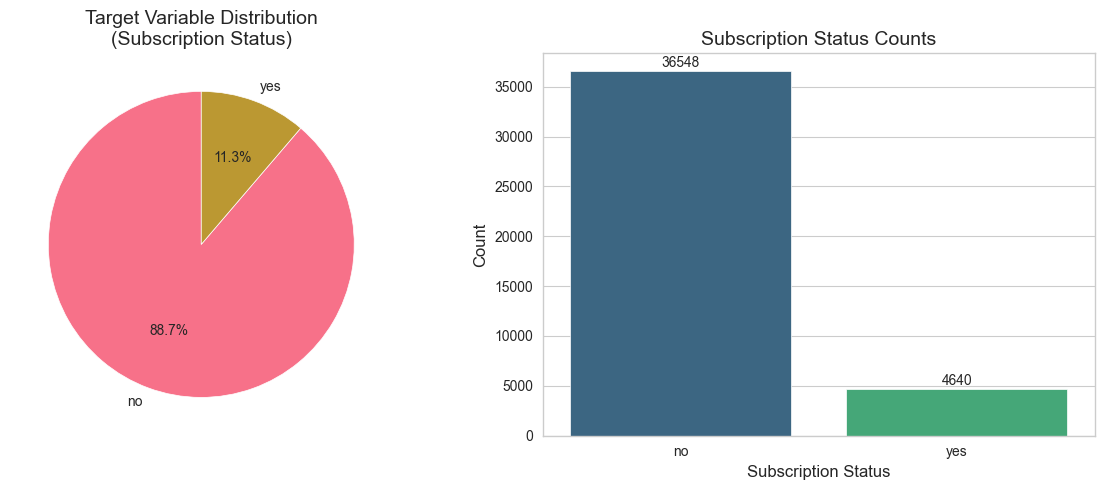

In [ ]:
print("\n" + "=" * 80)
print("5. RAW DATA VISUALIZATION AND PATTERNS (EDA FOCUS)")
print("=" * 80)

## 5.1 Target Variable Distribution Analysis
print("\n🎯 TARGET VARIABLE DISTRIBUTION (RAW DATA)")
print("-" * 50)

if target_col in df_raw.columns:
    # Create target distribution visualization
    plt.figure(figsize=(12, 5))

    # Subplot 1: Count plot
    plt.subplot(1, 2, 1)
    target_counts = df_raw[target_col].value_counts()
    plt.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Target Variable Distribution\n(Subscription Status)')

    # Subplot 2: Bar plot
    plt.subplot(1, 2, 2)
    sns.countplot(data=df_raw, x=target_col, palette='viridis')
    plt.title('Subscription Status Counts')
    plt.xlabel('Subscription Status')
    plt.ylabel('Count')

    # Add count labels on bars
    for i, v in enumerate(target_counts.values):
        plt.text(i, v + 100, str(v), ha='center', va='bottom')

    plt.tight_layout()
    save_figure("target_variable_distribution",
                "Target variable distribution showing subscription status with pie chart and bar plot")

    print(f"Target Variable Distribution:")
    for value, count in target_counts.items():
        pct = (count / len(df_raw)) * 100
        print(f"  {value}: {count:,} ({pct:.1f}%)")

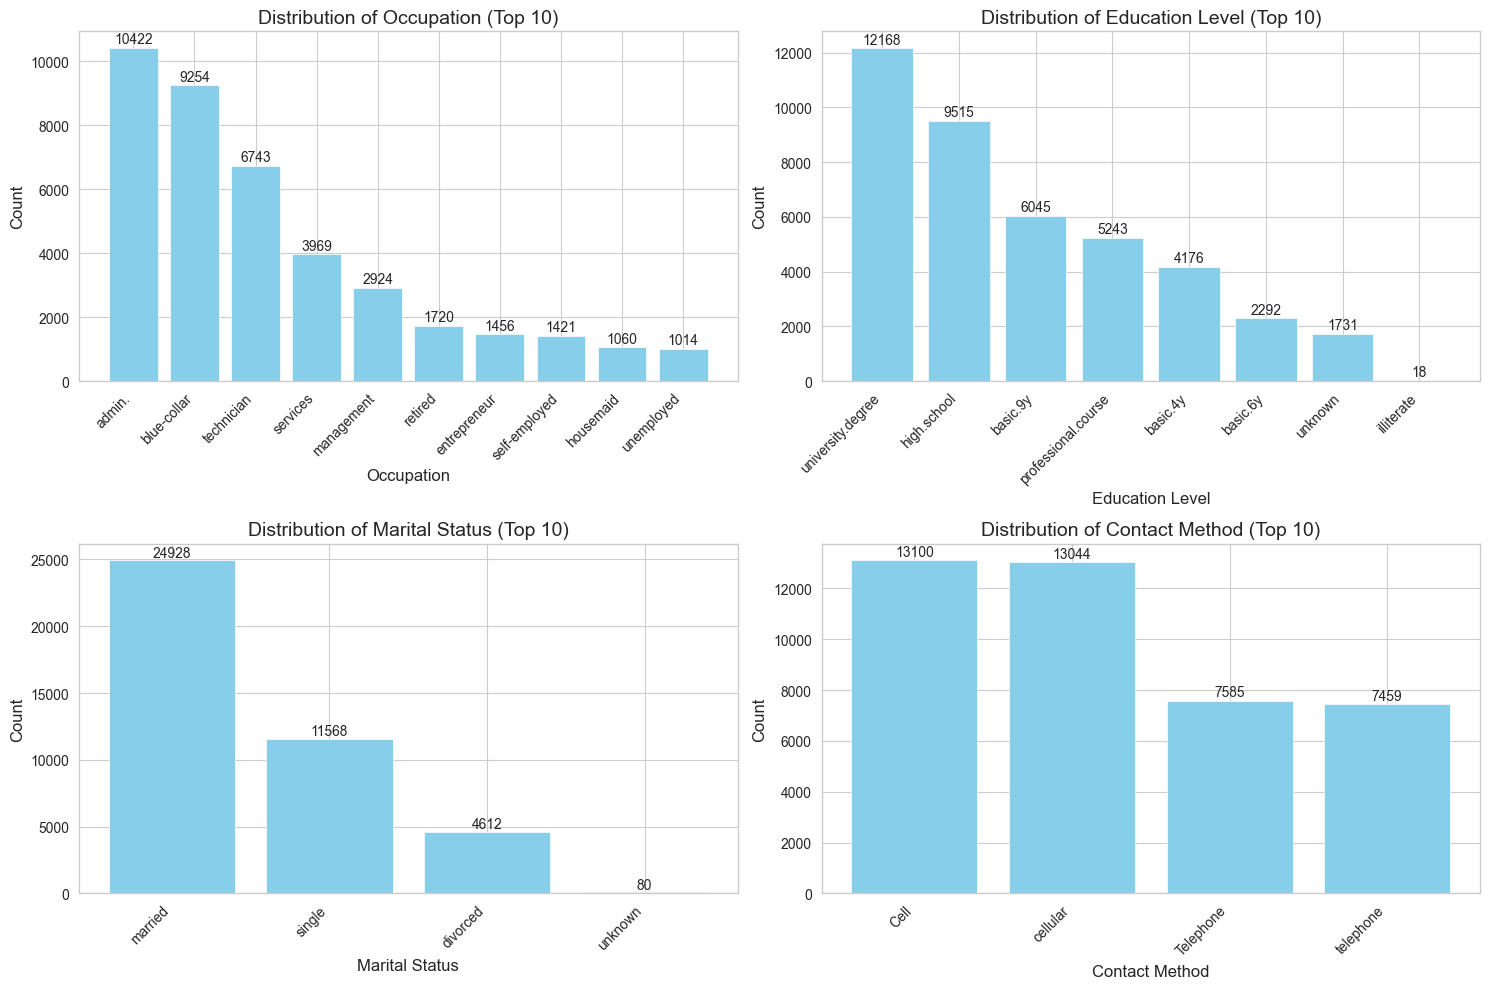

In [ ]:
## 5.2 Categorical Features Visualization
print("\n📊 CATEGORICAL FEATURES VISUALIZATION (RAW DATA)")
print("-" * 55)

# Select key categorical features for visualization
key_categorical = ['Occupation', 'Education Level', 'Marital Status', 'Contact Method']
available_categorical = [col for col in key_categorical if col in df_raw.columns]

if available_categorical:
    # Create subplots for categorical features
    n_features = len(available_categorical)
    n_cols = 2
    n_rows = (n_features + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()

    for i, col in enumerate(available_categorical):
        if i < len(axes):
            # Count plot for each categorical feature
            top_categories = df_raw[col].value_counts().head(10)

            axes[i].bar(range(len(top_categories)), top_categories.values, color='skyblue')
            axes[i].set_title(f'Distribution of {col} (Top 10)')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')
            axes[i].set_xticks(range(len(top_categories)))
            axes[i].set_xticklabels(top_categories.index, rotation=45, ha='right')

            # Add count labels
            for j, v in enumerate(top_categories.values):
                axes[i].text(j, v + 50, str(v), ha='center', va='bottom')

    # Remove empty subplots
    for i in range(len(available_categorical), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    save_figure("categorical_features_distribution",
                "Distribution of key categorical features showing top 10 categories for each feature")

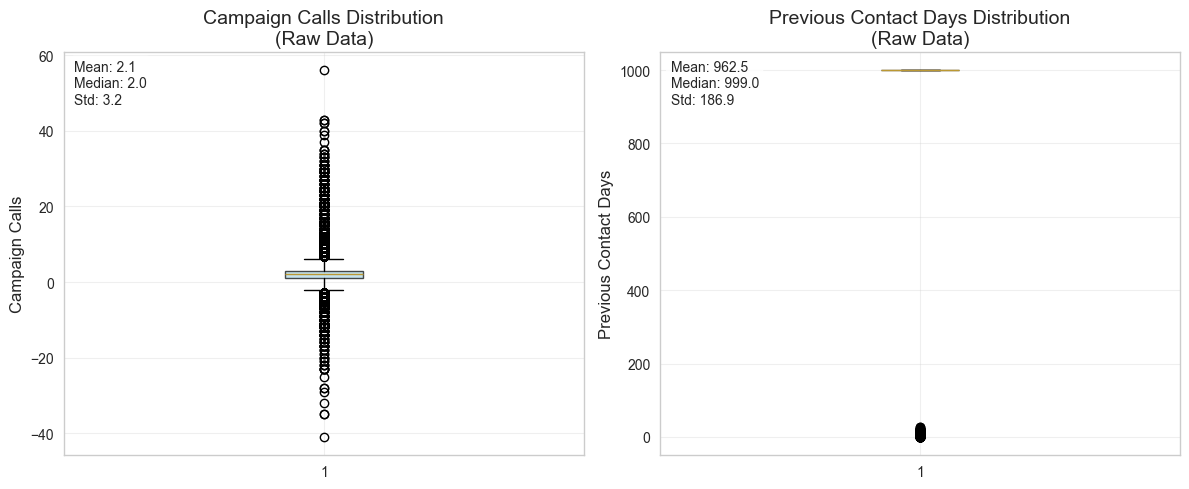

In [ ]:
## 5.3 Numerical Features Distribution Analysis
print("\n📊 NUMERICAL FEATURES DISTRIBUTION ANALYSIS")
print("-" * 50)

# Analyze numerical features in raw data
if numerical_cols:
    # Create distribution plots with business insights
    fig, axes = plt.subplots(1, len(numerical_cols), figsize=(6 * len(numerical_cols), 5))
    if len(numerical_cols) == 1:
        axes = [axes]

    for i, col in enumerate(numerical_cols):
        # Box plot to show distribution and outliers
        axes[i].boxplot(df_raw[col].dropna(), patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
        axes[i].set_title(f'{col} Distribution\n(Raw Data)')
        axes[i].set_ylabel(col)
        axes[i].grid(True, alpha=0.3)

        # Add statistics text
        stats_text = f"Mean: {df_raw[col].mean():.1f}\nMedian: {df_raw[col].median():.1f}\nStd: {df_raw[col].std():.1f}"
        axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    save_figure("numerical_features_boxplots",
                "Box plots showing distribution and outliers for numerical features with summary statistics")

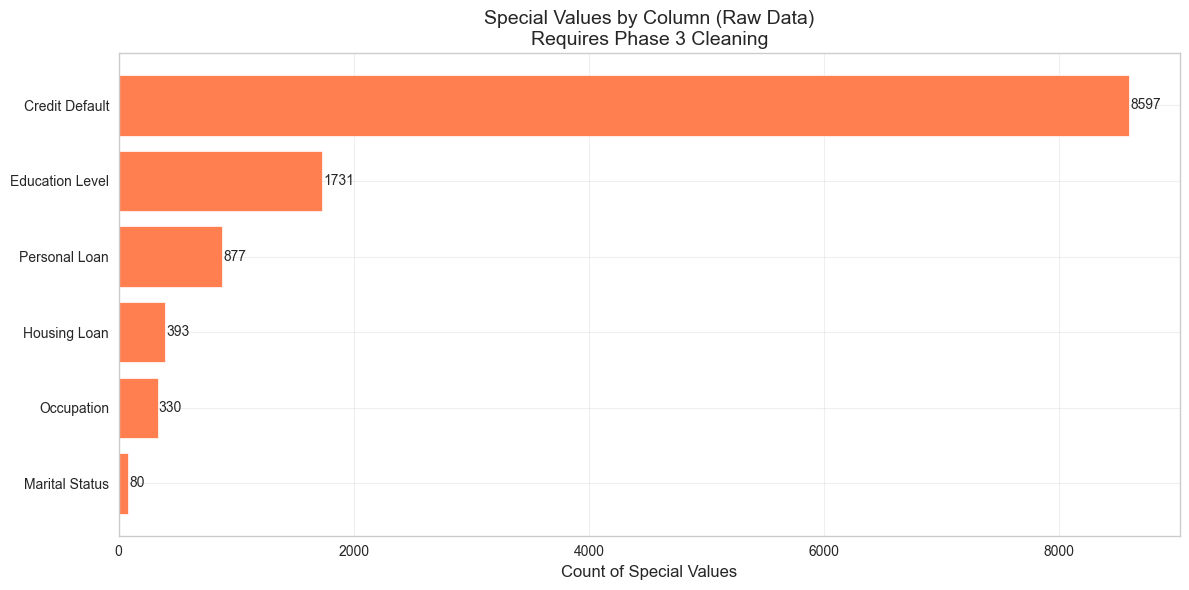

In [ ]:
## 5.4 Data Quality Patterns Visualization
print("\n🔍 DATA QUALITY PATTERNS VISUALIZATION")
print("-" * 45)

# Visualize missing and special values
if special_value_summary:
    # Create a summary of special values for visualization
    special_df = []
    for col, values in special_value_summary.items():
        for val, count in values.items():
            special_df.append({'Column': col, 'Special_Value': val, 'Count': count})

    if special_df:
        special_df = pd.DataFrame(special_df)

        # Create visualization
        plt.figure(figsize=(12, 6))

        # Group by column and sum counts
        col_totals = special_df.groupby('Column')['Count'].sum().sort_values(ascending=True)

        plt.barh(range(len(col_totals)), col_totals.values, color='coral')
        plt.yticks(range(len(col_totals)), col_totals.index)
        plt.xlabel('Count of Special Values')
        plt.title('Special Values by Column (Raw Data)\nRequires Phase 3 Cleaning')
        plt.grid(True, alpha=0.3)

        # Add count labels
        for i, v in enumerate(col_totals.values):
            plt.text(v + 10, i, str(v), va='center')

        plt.tight_layout()
        save_figure("data_quality_special_values",
                    "Special values by column requiring Phase 3 cleaning with counts and percentages")

        print("Special values requiring Phase 3 cleaning:")
        for col, count in col_totals.items():
            pct = (count / len(df_raw)) * 100
            print(f"  {col}: {count:,} special values ({pct:.1f}% of data)")

print("\n✅ Raw data visualization and pattern analysis completed")

In [ ]:
print("\n✅ Raw data visualization and pattern analysis completed")

In [ ]:
# 6. EDA INSIGHTS FOR PHASE 3 PREPARATION

In [ ]:
print("\n" + "=" * 80)
print("6. EDA INSIGHTS FOR PHASE 3 PREPARATION")
print("=" * 80)

## 6.1 Raw Data Patterns Summary
print("\n📋 RAW DATA PATTERNS SUMMARY")
print("-" * 35)

print("Key findings from raw data exploration:")

# Target variable insights
if target_col in df_raw.columns:
    target_dist = df_raw[target_col].value_counts(normalize=True) * 100
    print(f"\n🎯 Target Variable Insights:")
    for value, pct in target_dist.items():
        print(f"  • {value}: {pct:.1f}% of customers")

    # Class imbalance assessment
    if len(target_dist) == 2:
        minority_pct = target_dist.min()
        if minority_pct < 20:
            print(f"  ⚠️  Class imbalance detected: {minority_pct:.1f}% minority class")
            print("     → Phase 3 recommendation: Consider balancing techniques")

# Categorical features insights
print(f"\n📊 Categorical Features Insights:")
for col in categorical_cols:
    if col in df_raw.columns:
        unique_count = df_raw[col].nunique()
        most_common_pct = (df_raw[col].value_counts().iloc[0] / len(df_raw)) * 100
        print(f"  • {col}: {unique_count} categories, {most_common_pct:.1f}% in top category")

# Numerical features insights
print(f"\n📈 Numerical Features Insights:")
for col in numerical_cols:
    if col in df_raw.columns:
        mean_val = df_raw[col].mean()
        std_val = df_raw[col].std()
        cv = (std_val / mean_val) * 100 if mean_val != 0 else 0
        print(f"  • {col}: Mean={mean_val:.1f}, CV={cv:.1f}%")

In [ ]:
print("\n" + "=" * 80)
print("6. EDA INSIGHTS FOR PHASE 3 PREPARATION")
print("=" * 80)

In [ ]:
## 6.1 Raw Data Patterns Summary
print("\n📋 RAW DATA PATTERNS SUMMARY")
print("-" * 35)

print("Key findings from raw data exploration:")

In [ ]:
# Target variable insights
if target_col in df_raw.columns:
    target_dist = df_raw[target_col].value_counts(normalize=True) * 100
    print(f"\n🎯 Target Variable Insights:")
    for value, pct in target_dist.items():
        print(f"  • {value}: {pct:.1f}% of customers")

    # Class imbalance assessment
    if len(target_dist) == 2:
        minority_pct = target_dist.min()
        if minority_pct < 20:
            print(f"  ⚠️  Class imbalance detected: {minority_pct:.1f}% minority class")
            print("     → Phase 3 recommendation: Consider balancing techniques")

In [ ]:
# Categorical features insights
print(f"\n📊 Categorical Features Insights:")
for col in categorical_cols:
    if col in df_raw.columns:
        unique_count = df_raw[col].nunique()
        most_common_pct = (df_raw[col].value_counts().iloc[0] / len(df_raw)) * 100
        print(f"  • {col}: {unique_count} categories, {most_common_pct:.1f}% in top category")

In [ ]:
# Numerical features insights
print(f"\n📈 Numerical Features Insights:")
for col in numerical_cols:
    if col in df_raw.columns:
        mean_val = df_raw[col].mean()
        std_val = df_raw[col].std()
        cv = (std_val / mean_val) * 100 if mean_val != 0 else 0
        print(f"  • {col}: Mean={mean_val:.1f}, CV={cv:.1f}%")

In [ ]:
## 6.2 Data Quality Assessment for Phase 3
print("\n🔍 DATA QUALITY ASSESSMENT FOR PHASE 3")
print("-" * 45)

print("Data quality issues requiring Phase 3 attention:")

In [ ]:
# Missing values
missing_total = df_raw.isnull().sum().sum()
if missing_total > 0:
    print(f"  ⚠️  Missing values: {missing_total:,} total")
else:
    print("  ✅ No missing values detected")

# Special values summary
if special_value_summary:
    total_special = sum(sum(values.values()) for values in special_value_summary.values())
    print(f"  ⚠️  Special values: {total_special:,} total requiring cleaning")
    print("     → Most affected columns:")
    for col, values in special_value_summary.items():
        total_col = sum(values.values())
        pct = (total_col / len(df_raw)) * 100
        print(f"       - {col}: {total_col:,} ({pct:.1f}%)")

In [ ]:
# Data type issues
print(f"\n📝 Data Type Issues:")
if 'Age' in df_raw.columns and df_raw['Age'].dtype == 'object':
    print("  ⚠️  Age column stored as text - needs numeric conversion")

print("\n✅ EDA insights summary completed")

In [ ]:
# 7. PHASE 3 RECOMMENDATIONS BASED ON EDA FINDINGS

In [ ]:
print("\n" + "=" * 80)
print("7. PHASE 3 RECOMMENDATIONS BASED ON EDA FINDINGS")
print("=" * 80)

In [ ]:
## 7.1 Data Cleaning Recommendations
print("\n🔧 DATA CLEANING RECOMMENDATIONS FOR PHASE 3")
print("-" * 50)

print("Based on EDA findings, Phase 3 should implement:")

In [ ]:
# Missing values recommendations
missing_total = df_raw.isnull().sum().sum()
if missing_total > 0:
    print(f"\n1. Missing Values Handling:")
    print(f"   • Total missing values: {missing_total:,}")
    print("   • Recommended approach: Domain-specific imputation")
    print("   • Consider creating 'missing' indicator flags")

In [ ]:
# Special values recommendations
if special_value_summary:
    print(f"\n2. Special Values Cleaning:")
    for col, values in special_value_summary.items():
        total_col = sum(values.values())
        print(f"   • {col}: {total_col:,} special values")
        if 'unknown' in values:
            print(f"     → Handle 'unknown' as separate category or impute")
        if '999' in values:
            print(f"     → Convert '999' to meaningful values or flags")

In [ ]:
# Data type recommendations
print(f"\n3. Data Type Conversions:")
if 'Age' in df_raw.columns and df_raw['Age'].dtype == 'object':
    print("   • Convert Age from text to numeric")
    print("   • Extract numeric values using regex patterns")

In [ ]:
# Target encoding recommendations
if target_col in df_raw.columns:
    print(f"\n4. Target Variable Encoding:")
    print(f"   • Convert '{target_col}' to binary (1=yes, 0=no)")
    print("   • Ensure consistent encoding across dataset")

In [ ]:
## 7.2 Feature Engineering Recommendations
print("\n🛠️ FEATURE ENGINEERING RECOMMENDATIONS")
print("-" * 45)

print("Recommended feature engineering for Phase 3:")

print("\n1. Categorical Feature Engineering:")
print("   • One-hot encode low-cardinality features")
print("   • Label encode ordinal features (Education Level)")
print("   • Create interaction features (Occupation × Education)")

print("\n2. Numerical Feature Engineering:")
print("   • Create age groups/bins for better segmentation")
print("   • Normalize campaign calls and contact days")
print("   • Create campaign intensity categories")

print("\n3. Business Logic Features:")
print("   • Create 'No Previous Contact' binary flag")
print("   • Calculate days since last campaign")
print("   • Create customer risk profiles")

In [ ]:
## 7.3 Data Validation Recommendations
print("\n✅ DATA VALIDATION RECOMMENDATIONS")
print("-" * 40)

print("Implement these validation checks in Phase 3:")

print("\n1. Range Validations:")
print("   • Age: 18-100 years")
print("   • Campaign Calls: 1-50 (cap extreme values)")
print("   • Previous Contact Days: 0-999")

print("\n2. Consistency Checks:")
print("   • Standardize contact methods (cell/cellular)")
print("   • Validate education level categories")
print("   • Check occupation consistency")

print("\n3. Business Rule Validations:")
print("   • Ensure logical relationships between features")
print("   • Validate campaign timing constraints")
print("   • Check for impossible combinations")

print("\n✅ Phase 3 recommendations completed")

In [ ]:
# 8. EDA SUMMARY AND NEXT STEPS FOR PHASE 3

In [ ]:
print("\n" + "=" * 80)
print("8. EDA SUMMARY AND NEXT STEPS FOR PHASE 3")
print("=" * 80)

In [ ]:
## 8.1 EDA Key Findings Summary
print("\n🎯 KEY EDA FINDINGS (RAW DATA ANALYSIS)")
print("-" * 45)

print("Summary of raw data exploration findings:")

In [ ]:
# Target distribution insight
if target_col in df_raw.columns:
    target_dist = df_raw[target_col].value_counts(normalize=True)
    positive_rate = target_dist.get('yes', 0) * 100
    print(f"\n📊 Target Variable Insights:")
    print(f"  • Overall subscription rate: {positive_rate:.1f}%")

    # Class balance assessment
    if len(target_dist) == 2:
        minority_pct = target_dist.min() * 100
        majority_pct = target_dist.max() * 100
        imbalance_ratio = majority_pct / minority_pct
        print(f"  • Class distribution: {majority_pct:.1f}% / {minority_pct:.1f}%")
        print(f"  • Imbalance ratio: {imbalance_ratio:.1f}:1")

In [ ]:
# Data quality insights
print(f"\n🔍 Data Quality Insights:")
print(f"  • Dataset size: {len(df_raw):,} records")
print(f"  • Feature count: {len(df_raw.columns)} columns")

In [ ]:
# Data quality insights
print(f"\n🔍 Data Quality Insights:")
print(f"  • Dataset size: {len(df_raw):,} records")
print(f"  • Feature count: {len(df_raw.columns)} columns")

missing_total = df_raw.isnull().sum().sum()
if missing_total > 0:
    print(f"  • Missing values: {missing_total:,} total")
else:
    print("  • Missing values: None detected")

if special_value_summary:
    total_special = sum(sum(values.values()) for values in special_value_summary.values())
    print(f"  • Special values: {total_special:,} requiring cleaning")

In [ ]:
# Feature insights
print(f"\n📈 Feature Insights:")
print(f"  • Categorical features: {len(categorical_cols)} identified")
print(f"  • Numerical features: {len(numerical_cols)} identified")
print(f"  • Age data type: {'Text (needs conversion)' if 'Age' in df_raw.columns and df_raw['Age'].dtype == 'object' else 'Numeric'}")

In [ ]:
## 8.2 Phase 3 Preparation Checklist
print("\n✅ PHASE 3 PREPARATION CHECKLIST")
print("-" * 40)

print("Ready for Phase 3 implementation:")

checklist_items = [
    "✅ Raw data structure understood",
    "✅ Target variable distribution analyzed",
    "✅ Data quality issues identified",
    "✅ Special values catalogued",
    "✅ Feature types classified",
    "✅ Business patterns explored",
    "✅ Cleaning requirements documented",
    "✅ Visualization insights captured"
]

for item in checklist_items:
    print(f"  {item}")

In [ ]:
## 8.3 Critical Phase 3 Tasks
print("\n🚀 CRITICAL PHASE 3 TASKS")
print("-" * 30)

critical_tasks = [
    "1. Data Cleaning Pipeline:",
    "   • Convert Age from text to numeric",
    "   • Handle special values (999, unknown)",
    "   • Create binary target encoding",
    "   • Implement missing value strategies",
    "",
    "2. Feature Engineering:",
    "   • Create age group categories",
    "   • Engineer campaign intensity features",
    "   • Build interaction features",
    "   • Generate business logic flags",
    "",
    "3. Data Validation:",
    "   • Implement range checks",
    "   • Validate business rules",
    "   • Ensure data consistency",
    "   • Create quality metrics",
    "",
    "4. Pipeline Integration:",
    "   • Build reusable cleaning functions",
    "   • Create data transformation pipeline",
    "   • Implement error handling",
    "   • Document transformation logic"
]

for task in critical_tasks:
    print(task)

In [ ]:
## 8.4 Success Metrics for Phase 3
print("\n📊 SUCCESS METRICS FOR PHASE 3")
print("-" * 35)

success_metrics = [
    "Data Quality Metrics:",
    f"  • Target: 0 missing values (currently: {missing_total:,})",
    f"  • Target: 0 special values (currently: {total_special if special_value_summary else 0:,})",
    "  • Target: All features properly typed",
    "  • Target: 100% data validation pass rate",
    "",
    "Feature Engineering Metrics:",
    "  • Target: Age successfully converted to numeric",
    "  • Target: All categorical features encoded",
    "  • Target: Business logic features created",
    "  • Target: Feature correlation analysis completed",
    "",
    "Pipeline Metrics:",
    "  • Target: End-to-end pipeline functional",
    "  • Target: Reproducible transformations",
    "  • Target: Comprehensive error handling",
    "  • Target: Complete documentation"
]

for metric in success_metrics:
    print(metric)

In [ ]:
# 9. EDA CONCLUSION

In [ ]:
print("\n" + "=" * 80)
print("9. EDA CONCLUSION")
print("=" * 80)

print("\n🎯 EDA COMPLETION SUMMARY")
print("-" * 30)

completion_summary = [
    f"✅ Analyzed {len(df_raw):,} banking clients from bmarket.db",
    f"✅ Explored {len(df_raw.columns)} raw features including demographics and campaign data",
    f"✅ Identified data quality issues requiring Phase 3 cleaning",
    f"✅ Documented special values and data type conversion needs",
    f"✅ Visualized raw data patterns and distributions",
    f"✅ Provided comprehensive Phase 3 preparation roadmap"
]

for item in completion_summary:
    print(item)

In [ ]:
print("\n📋 EDA DELIVERABLES")
print("-" * 25)

deliverables = [
    "✅ Raw data structure analysis",
    "✅ Target variable distribution insights",
    "✅ Feature type classification",
    "✅ Data quality assessment report",
    "✅ Special values inventory",
    "✅ Visualization insights",
    "✅ Phase 3 cleaning requirements",
    "✅ Feature engineering recommendations"
]

for item in deliverables:
    print(f"  {item}")

In [ ]:
print("\n🚀 READY FOR PHASE 3: DATA CLEANING AND PREPROCESSING")
print("-" * 60)

phase3_readiness = [
    "Phase 3 Prerequisites Met:",
    "  ✅ Raw data thoroughly understood",
    "  ✅ Cleaning requirements documented",
    "  ✅ Feature engineering strategy defined",
    "  ✅ Data validation rules identified",
    "  ✅ Business logic requirements captured",
    "",
    "Phase 3 Implementation Ready:",
    "  → Age text-to-numeric conversion pipeline",
    "  → Special value handling strategies",
    "  → Target variable binary encoding",
    "  → Feature engineering transformations",
    "  → Data validation framework",
    "  → Quality metrics implementation"
]

for item in phase3_readiness:
    print(item)

In [ ]:
print("\n" + "=" * 80)
print("EDA PHASE COMPLETED SUCCESSFULLY")
print("PROCEED TO PHASE 3: DATA CLEANING AND PREPROCESSING")
print("=" * 80)

print("\n🎉 Raw Data EDA Analysis Complete! 🎉")
print("📊 All insights captured for Phase 3 implementation")
print("🔧 Ready to build data cleaning and preprocessing pipeline")